In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


# drive/"My Drive"/Colab_Notebooks/Word2Vec/simpsons_dataset.csv

In [0]:
#df = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/Dataset/Human/Demian_Eng_Human_Translated.csv')
#df = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/alice_in_wonderland.csv')
df_Human = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/Dataset/Human/Prince_Eng_Human_Translated.csv', encoding='cp1252')
df_DeepL = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/Dataset/DeepL/Prince_Eng_DeepL_Translated.csv', encoding='cp1252')
df_Google = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/Dataset/Google/Prince_Eng_Google_Translated.csv', encoding='cp1252')
df_Microsoft = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/Dataset/Microsoft/Prince_Eng_Microsoft_Translated.csv', encoding='cp1252')
df_Papago = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/Dataset/Papago/Prince_Eng_Papago_Translated.csv', encoding='cp1252')
df_Original = pd.read_csv('drive/My Drive/Colab_Notebooks/Word2Vec/Dataset/Prince_Fr_Original.csv', encoding='cp1252')

print(df_Human.shape)
print(df_DeepL.shape)
print(df_Google.shape)
print(df_Microsoft.shape)
print(df_Papago.shape)
print(df_Original.shape)

(4321, 2)
(4626, 2)
(4708, 2)
(1673, 2)
(4435, 2)
(1847, 2)


In [0]:
print(df_Human.head())
print(df_DeepL.head())
print(df_Google.head())
print(df_Microsoft.head())
print(df_Papago.head())
print(df_Original.head())

   raw_character_text                                       spoken_words
0                 1.0                                 THE LITTLE PRINCE 
1                 2.0                                                NaN
2                 3.0                                                NaN
3                 4.0  Once when I was six years old I saw a magnific...
4                 5.0  Nature, about the primeval forest. It was a pi...
   raw_character_text                                       spoken_words
0                 1.0                                  The Little Prince
1                 2.0                                                NaN
2                 3.0                                      FIRST CHAPTER
3                 4.0  When I was six years old, I once saw a beautif...
4                 5.0                                                NaN
   raw_character_text                                       spoken_words
0                 1.0                              

In [0]:
print(df_Human.isnull().sum())
print(df_DeepL.isnull().sum())
print(df_Google.isnull().sum())

print(df_Microsoft.isnull().sum())
print(df_Papago.isnull().sum())
print(df_Original.isnull().sum())

raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64


In [0]:
df_Human = df_Human.dropna().reset_index(drop=True)
df_DeepL = df_DeepL.dropna().reset_index(drop=True)
df_Google = df_Google.dropna().reset_index(drop=True)
df_Microsoft = df_Microsoft.dropna().reset_index(drop=True)
df_Papago = df_Papago.dropna().reset_index(drop=True)
df_Original = df_Original.dropna().reset_index(drop=True)

print(df_Human.isnull().sum())
print(df_DeepL.isnull().sum())
print(df_Google.isnull().sum())
print(df_Microsoft.isnull().sum())
print(df_Papago.isnull().sum())
print(df_Original.isnull().sum())


raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64
raw_character_text    0
spoken_words          0
dtype: int64


In [0]:
print(df_Human.shape)
print(df_DeepL.shape)
print(df_Google.shape)
print(df_Microsoft.shape)
print(df_Papago.shape)
print(df_Original.shape)


(1165, 2)
(939, 2)
(819, 2)
(939, 2)
(933, 2)
(934, 2)


In [0]:
df_Human.head()

,raw_character_text,spoken_words
0,1.0,THE LITTLE PRINCE
1,4.0,Once when I was six years old I saw a magnific...
2,5.0,"Nature, about the primeval forest. It was a pi..."
3,6.0,animal. Here is a copy of the drawing.
4,8.0,In the book it said: ¡°Boa constrictors swallo...


In [0]:
from spacy.lang.fr.examples import sentences

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [0]:
print(df_Human['spoken_words'].shape)
brief_cleaning_Human = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_Human['spoken_words'])
brief_cleaning_DeepL = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_DeepL['spoken_words'])
brief_cleaning_Google = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_Google['spoken_words'])
brief_cleaning_Microsoft = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_Microsoft['spoken_words'])
brief_cleaning_Papago = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_Papago['spoken_words'])
brief_cleaning_Original = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_Original['spoken_words'])

(1165,)


In [0]:
print(brief_cleaning_Human)
print(brief_cleaning_DeepL)
print(brief_cleaning_Google)
print(brief_cleaning_Microsoft)
print(brief_cleaning_Papago)
print(brief_cleaning_Original)

<generator object <genexpr> at 0x7fc12f07bf68>
<generator object <genexpr> at 0x7fc12e2b3d00>
<generator object <genexpr> at 0x7fc12e2b3990>
<generator object <genexpr> at 0x7fc12e2b3af0>
<generator object <genexpr> at 0x7fc12e2b3c50>
<generator object <genexpr> at 0x7fc12e2b3e60>


In [0]:
txt_Human = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_Human, batch_size=5000, n_threads=-1)]
txt_DeepL = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_DeepL, batch_size=5000, n_threads=-1)]
txt_Google = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_Google, batch_size=5000, n_threads=-1)]
txt_Microsoft = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_Microsoft, batch_size=5000, n_threads=-1)]
txt_Papago = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_Papago, batch_size=5000, n_threads=-1)]
txt_Original = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_Original, batch_size=5000, n_threads=-1)]

In [0]:
print(txt_Human)
print(txt_Google)

[None, 'year old see magnificent picture book call true story', 'nature primeval forest picture boa constrictor act swallow', 'animal copy drawing', 'book say boa constrictor swallow prey chew', 'able sleep month need digestion', 'ponder deeply adventure jungle work colour', 'pencil succeed make draw drawing number look like', 'show masterpiece grown up ask drawing frighten', 'answer frighten frighten hat drawing', 'picture hat picture boa constrictor digest elephant grown', 'up able understand drawing draw inside boa', 'constrictor grow up clearly need thing explain', 'drawing number look like', 'grow up response time advise lay aside drawing boa', 'constrictor inside outside devote instead geography', 'history arithmetic grammar age give', 'magnificent career painter dishearten failure drawing number', 'drawing number grow up understand', 'tiresome child forever explain thing', 'choose profession learn pilot air plane fly little', 'part world true geography useful glance', 'distingui

In [0]:
df_clean_Human = pd.DataFrame({'clean': txt_Human})
df_clean_Human = df_clean_Human.dropna().drop_duplicates()
df_clean_Human.shape

(1015, 1)

In [0]:
df_clean_DeepL = pd.DataFrame({'clean': txt_DeepL})
df_clean_DeepL = df_clean_DeepL.dropna().drop_duplicates()
df_clean_DeepL.shape
df_clean_DeepL.head()

,clean
2,year old see beautiful image book virgin fores...
3,book say boas snake swallow entire prey chew n...
4,think lot adventure jungle turn manage colour ...
5,show masterpiece grown up ask afraid drawing
6,say hat scary


In [0]:
df_clean_Google = pd.DataFrame({'clean': txt_Google})
df_clean_Google = df_clean_Google.dropna().drop_duplicates()
df_clean_Google.shape

(668, 1)

In [0]:
df_clean_Microsoft = pd.DataFrame({'clean': txt_Microsoft})
df_clean_Microsoft = df_clean_Microsoft.dropna().drop_duplicates()
df_clean_Microsoft.shape

(767, 1)

In [0]:
df_clean_Papago = pd.DataFrame({'clean': txt_Papago})
df_clean_Papago = df_clean_Papago.dropna().drop_duplicates()
df_clean_Papago.shape

(766, 1)

In [0]:
df_clean_Original = pd.DataFrame({'clean': txt_Original})
df_clean_Original = df_clean_Original.dropna().drop_duplicates()
df_clean_Original.shape

(864, 1)

In [0]:
print(df_clean_Human)
print(df_clean_DeepL)
print(df_clean_Google)
print(df_clean_Microsoft)
print(df_clean_Papago)
print(df_clean_Original)

In [0]:
pip install paramiko

     |████████████████████████████████| 194kB 41.1MB/s 
     |████████████████████████████████| 768kB 45.2MB/s 
     |████████████████████████████████| 61kB 23.4MB/s 
     |████████████████████████████████| 2.3MB 48.5MB/s 
     |████████████████████████████████| 102kB 29.2MB/s 


In [0]:
from gensim.models.phrases import Phrases, Phraser

INFO - 13:19:02: 'pattern' package not found; tag filters are not available for English


In [0]:
sent_Human = [row.split() for row in df_clean_Human['clean']]
sent_DeepL = [row.split() for row in df_clean_DeepL['clean']]
sent_Google = [row.split() for row in df_clean_Google['clean']]
sent_Microsoft = [row.split() for row in df_clean_Microsoft['clean']]
sent_Papago = [row.split() for row in df_clean_Papago['clean']]
sent_Original = [row.split() for row in df_clean_Original['clean']]



In [0]:
phrases_Human = Phrases(sent_Human, min_count=5, progress_per=10000)
print("---------------------------------------------------Finished----------------------------------------------------------------------")
phrases_DeepL = Phrases(sent_DeepL, min_count=5, progress_per=10000)
print("---------------------------------------------------Finished----------------------------------------------------------------------")
phrases_Google = Phrases(sent_Google, min_count=5, progress_per=10000)
print("---------------------------------------------------Finished----------------------------------------------------------------------")
phrases_Microsoft = Phrases(sent_Microsoft, min_count=5, progress_per=10000)
print("---------------------------------------------------Finished----------------------------------------------------------------------")
phrases_Papago = Phrases(sent_Papago, min_count=5, progress_per=10000)
print("---------------------------------------------------Finished----------------------------------------------------------------------")
phrases_Original = Phrases(sent_Original, min_count=5, progress_per=10000)
print("---------------------------------------------------Finished----------------------------------------------------------------------")


INFO - 13:20:04: collecting all words and their counts
INFO - 13:20:04: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:20:04: collected 5524 word types from a corpus of 5949 words (unigram + bigrams) and 1015 sentences
INFO - 13:20:04: using 5524 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
INFO - 13:20:04: collecting all words and their counts
INFO - 13:20:04: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:20:04: collected 5134 word types from a corpus of 5516 words (unigram + bigrams) and 774 sentences
INFO - 13:20:04: using 5134 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
INFO - 13:20:04: collecting all words and their counts
INFO - 13:20:04: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:20:04: collected 5130 word types from a corpus of 5258 words (unigram + bigrams) and 668 sentences
INFO - 13:20:04: using 5130 counts as

---------------------------------------------------Finished----------------------------------------------------------------------
---------------------------------------------------Finished----------------------------------------------------------------------
---------------------------------------------------Finished----------------------------------------------------------------------
---------------------------------------------------Finished----------------------------------------------------------------------
---------------------------------------------------Finished----------------------------------------------------------------------
---------------------------------------------------Finished----------------------------------------------------------------------


In [0]:
bigram_Human = Phraser(phrases_Human)
bigram_DeepL = Phraser(phrases_DeepL)
bigram_Google = Phraser(phrases_Google)
bigram_Microsoft = Phraser(phrases_Microsoft)
bigram_Papago = Phraser(phrases_Papago)
bigram_Original = Phraser(phrases_Original)


INFO - 13:25:53: source_vocab length 5524
INFO - 13:25:53: Phraser built with 11 phrasegrams
INFO - 13:25:53: source_vocab length 5134
INFO - 13:25:53: Phraser built with 8 phrasegrams
INFO - 13:25:53: source_vocab length 5130
INFO - 13:25:53: Phraser built with 8 phrasegrams
INFO - 13:25:53: source_vocab length 5154
INFO - 13:25:53: Phraser built with 6 phrasegrams
INFO - 13:25:53: source_vocab length 5140
INFO - 13:25:53: Phraser built with 6 phrasegrams
INFO - 13:25:53: source_vocab length 10988
INFO - 13:25:53: Phraser built with 75 phrasegrams


In [0]:
sentences_Human = bigram_Human[sent_Human]
sentences_DeepL = bigram_DeepL[sent_DeepL]
sentences_Google = bigram_Google[sent_Google]
sentences_Microsoft = bigram_Microsoft[sent_Microsoft]
sentences_Papago = bigram_Papago[sent_Papago]
sentences_Original = bigram_Original[sent_Original]


sentences_Human
sentences_DeepL
sentences_Google
sentences_Microsoft
print(sentences_Papago)

In [0]:
word_freq_Human = defaultdict(int)
for sent in sentences_Human:
    for i in sent:
        word_freq_Human[i] += 1
len(word_freq_Human)

1461

In [0]:
word_freq_DeepL = defaultdict(int)
for sent in sentences_DeepL:
    for i in sent:
        word_freq_DeepL[i] += 1
len(word_freq_DeepL)

1286

In [0]:
word_freq_Google = defaultdict(int)
for sent in sentences_Google:
    for i in sent:
        word_freq_Google[i] += 1
len(word_freq_Google)

1323

In [0]:
word_freq_Microsoft = defaultdict(int)
for sent in sentences_Microsoft:
    for i in sent:
        word_freq_Microsoft[i] += 1
len(word_freq_Microsoft)

1348

In [0]:
word_freq_Papago = defaultdict(int)
for sent in sentences_Papago:
    for i in sent:
        word_freq_Papago[i] += 1
len(word_freq_Papago)

1335

In [0]:
word_freq_Original = defaultdict(int)
for sent in sentences_Original:
    for i in sent:
        word_freq_Original[i] += 1
len(word_freq_Original)

2395

In [0]:
print(sorted(word_freq_Human, key=word_freq_Human.get, reverse=True)[:10])
print(sorted(word_freq_DeepL, key=word_freq_DeepL.get, reverse=True)[:10])
print(sorted(word_freq_Google, key=word_freq_Google.get, reverse=True)[:10])
print(sorted(word_freq_Microsoft, key=word_freq_Microsoft.get, reverse=True)[:10])
print(sorted(word_freq_Papago, key=word_freq_Papago.get, reverse=True)[:10])
print(sorted(word_freq_Original, key=word_freq_Original.get, reverse=True)[:10])




['say', 'little_prince', 'little', 'planet', 'flower', 'come', 'look', 'know', 'like', 'star']
['be', 'little_prince', 'not', 'say', 'like', 'little', 'flower', 'planet', 'know', 'look']
['little_prince', 'be', 'say', 'like', 'know', 'flower', 'planet', 'little', 'look', 'star']
['little_prince', 'be', 'say', 'know', 'flower', 'little', 'like', 'planet', 'look', 'not']
['little_prince', 'be', 'say', 'not', 'like', 'know', 'flower', 'planet', 'look', 'little']
['de', 'il', 'et', 'je', 'le', 'un', 'les', 'pas', 'la', 'ne']


In [0]:
import multiprocessing

from gensim.models import Word2Vec

In [0]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [0]:
w2v_model_Human = Word2Vec(min_count=5, window=5, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
w2v_model_DeepL = Word2Vec(min_count=5, window=5, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
w2v_model_Google = Word2Vec(min_count=5, window=5, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
w2v_model_Microsoft = Word2Vec(min_count=5, window=5, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
w2v_model_Papago = Word2Vec(min_count=5, window=5, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
w2v_model_Original = Word2Vec(min_count=5, window=5, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

In [0]:
print(w2v_model_Human)
print(w2v_model_DeepL)
print(w2v_model_Google)
print(w2v_model_Microsoft)
print(w2v_model_Papago)
print(w2v_model_Original)

Word2Vec(vocab=0, size=300, alpha=0.03)
Word2Vec(vocab=0, size=300, alpha=0.03)
Word2Vec(vocab=0, size=300, alpha=0.03)
Word2Vec(vocab=0, size=300, alpha=0.03)
Word2Vec(vocab=0, size=300, alpha=0.03)
Word2Vec(vocab=0, size=300, alpha=0.03)


In [0]:
w2v_model_Human.build_vocab(sentences_Human, progress_per = 10000)
print("-------------------------Done------------------------------------")
w2v_model_DeepL.build_vocab(sentences_DeepL, progress_per = 10000)
print("-------------------------Done------------------------------------")
w2v_model_Google.build_vocab(sentences_Google, progress_per = 10000)
print("-------------------------Done------------------------------------")
w2v_model_Microsoft.build_vocab(sentences_Microsoft, progress_per = 10000)
print("-------------------------Done------------------------------------")
w2v_model_Papago.build_vocab(sentences_Papago, progress_per = 10000)
print("-------------------------Done------------------------------------")
w2v_model_Original.build_vocab(sentences_Original, progress_per = 10000)
print("-------------------------Done------------------------------------")

In [0]:
total_examples_H = w2v_model_Human.corpus_count
total_examples_D = w2v_model_DeepL.corpus_count
total_examples_G = w2v_model_Google.corpus_count
total_examples_M = w2v_model_Microsoft.corpus_count
total_examples_P = w2v_model_Papago.corpus_count
total_examples_O = w2v_model_Original.corpus_count
print(total_examples_P)

1


In [0]:
#from gensim.models import KeyedVectors
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin", binary=True)
w2v_model_Human.build_vocab([list(model.vocab.keys())], update=True)
print("-------------------------Done------------------------------------")
w2v_model_DeepL.build_vocab([list(model.vocab.keys())], update=True)
print("-------------------------Done------------------------------------")
w2v_model_Google.build_vocab([list(model.vocab.keys())], update=True)
print("-------------------------Done------------------------------------")
w2v_model_Microsoft.build_vocab([list(model.vocab.keys())], update=True)
print("-------------------------Done------------------------------------")
w2v_model_Papago.build_vocab([list(model.vocab.keys())], update=True)
print("-------------------------Done------------------------------------")
w2v_model_Original.build_vocab([list(model.vocab.keys())], update=True)
print("-------------------------Done------------------------------------")

INFO - 13:29:26: loading projection weights from /content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin
WARNING - 13:29:26: this function is deprecated, use smart_open.open instead
INFO - 13:30:28: loaded (3000000, 300) matrix from /content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin
INFO - 13:30:28: collecting all words and their counts
INFO - 13:30:28: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:30:29: collected 3000000 word types from a corpus of 3000000 raw words and 1 sentences
INFO - 13:30:29: Updating model with new vocabulary
INFO - 13:30:31: New added 0 unique words (0% of original 3000000) and increased the count of 0 pre-existing words (0% of original 3000000)
INFO - 13:30:31: deleting the raw counts dictionary of 3000000 items
INFO - 13:30:31: sample=6e-05 downsamples 0 most-common words
INFO - 13:30:31: downsampling leaves estimated 0 word corpus (0.0% of prior 0)
INFO - 13:30:31: e

-------------------------Done------------------------------------


INFO - 13:30:32: collected 3000000 word types from a corpus of 3000000 raw words and 1 sentences
INFO - 13:30:32: Updating model with new vocabulary
INFO - 13:30:33: New added 0 unique words (0% of original 3000000) and increased the count of 0 pre-existing words (0% of original 3000000)
INFO - 13:30:33: deleting the raw counts dictionary of 3000000 items
INFO - 13:30:34: sample=6e-05 downsamples 0 most-common words
INFO - 13:30:34: downsampling leaves estimated 0 word corpus (0.0% of prior 0)
INFO - 13:30:34: estimated required memory for 240 words and 300 dimensions: 696000 bytes
INFO - 13:30:34: updating layer weights
INFO - 13:30:34: collecting all words and their counts
INFO - 13:30:34: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


-------------------------Done------------------------------------


INFO - 13:30:35: collected 3000000 word types from a corpus of 3000000 raw words and 1 sentences
INFO - 13:30:35: Updating model with new vocabulary
INFO - 13:30:36: New added 0 unique words (0% of original 3000000) and increased the count of 0 pre-existing words (0% of original 3000000)
INFO - 13:30:36: deleting the raw counts dictionary of 3000000 items
INFO - 13:30:36: sample=6e-05 downsamples 0 most-common words
INFO - 13:30:36: downsampling leaves estimated 0 word corpus (0.0% of prior 0)
INFO - 13:30:36: estimated required memory for 226 words and 300 dimensions: 655400 bytes
INFO - 13:30:36: updating layer weights
INFO - 13:30:37: collecting all words and their counts
INFO - 13:30:37: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


-------------------------Done------------------------------------


INFO - 13:30:38: collected 3000000 word types from a corpus of 3000000 raw words and 1 sentences
INFO - 13:30:38: Updating model with new vocabulary
INFO - 13:30:39: New added 0 unique words (0% of original 3000000) and increased the count of 0 pre-existing words (0% of original 3000000)
INFO - 13:30:39: deleting the raw counts dictionary of 3000000 items
INFO - 13:30:39: sample=6e-05 downsamples 0 most-common words
INFO - 13:30:39: downsampling leaves estimated 0 word corpus (0.0% of prior 0)
INFO - 13:30:39: estimated required memory for 234 words and 300 dimensions: 678600 bytes
INFO - 13:30:39: updating layer weights
INFO - 13:30:39: collecting all words and their counts
INFO - 13:30:39: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


-------------------------Done------------------------------------


INFO - 13:30:41: collected 3000000 word types from a corpus of 3000000 raw words and 1 sentences
INFO - 13:30:41: Updating model with new vocabulary
INFO - 13:30:42: New added 0 unique words (0% of original 3000000) and increased the count of 0 pre-existing words (0% of original 3000000)
INFO - 13:30:42: deleting the raw counts dictionary of 3000000 items
INFO - 13:30:42: sample=6e-05 downsamples 0 most-common words
INFO - 13:30:42: downsampling leaves estimated 0 word corpus (0.0% of prior 0)
INFO - 13:30:42: estimated required memory for 247 words and 300 dimensions: 716300 bytes
INFO - 13:30:42: updating layer weights
INFO - 13:30:42: collecting all words and their counts
INFO - 13:30:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


-------------------------Done------------------------------------


INFO - 13:30:44: collected 3000000 word types from a corpus of 3000000 raw words and 1 sentences
INFO - 13:30:44: Updating model with new vocabulary
INFO - 13:30:45: New added 0 unique words (0% of original 3000000) and increased the count of 0 pre-existing words (0% of original 3000000)
INFO - 13:30:45: deleting the raw counts dictionary of 3000000 items
INFO - 13:30:45: sample=6e-05 downsamples 0 most-common words
INFO - 13:30:45: downsampling leaves estimated 0 word corpus (0.0% of prior 0)
INFO - 13:30:45: estimated required memory for 444 words and 300 dimensions: 1287600 bytes
INFO - 13:30:45: updating layer weights


-------------------------Done------------------------------------


In [0]:
w2v_model_Human.intersect_word2vec_format("/content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
print("-------------------------Done------------------------------------")
w2v_model_DeepL.intersect_word2vec_format("/content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
print("-------------------------Done------------------------------------")
w2v_model_Google.intersect_word2vec_format("/content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
print("-------------------------Done------------------------------------")
w2v_model_Microsoft.intersect_word2vec_format("/content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
print("-------------------------Done------------------------------------")
w2v_model_Papago.intersect_word2vec_format("/content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
print("-------------------------Done------------------------------------")
w2v_model_Original.intersect_word2vec_format("/content/drive/My Drive/Colab_Notebooks/Word2Vec/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
print("-------------------------Done------------------------------------")

In [0]:
w2v_model_Human.train(sentences_Human, total_examples=total_examples_H, epochs=30, report_delay=1)
print("----------------------------------Done----------------------------------")
w2v_model_DeepL.train(sentences_DeepL, total_examples=total_examples_D, epochs=30, report_delay=1)
print("----------------------------------Done----------------------------------")
w2v_model_Google.train(sentences_Google, total_examples=total_examples_G, epochs=30, report_delay=1)
print("----------------------------------Done----------------------------------")
w2v_model_Microsoft.train(sentences_Microsoft, total_examples=total_examples_M, epochs=30, report_delay=1)
print("----------------------------------Done----------------------------------")
w2v_model_Papago.train(sentences_Papago, total_examples=total_examples_P, epochs=30, report_delay=1)
print("----------------------------------Done----------------------------------")
w2v_model_Original.train(sentences_Original, total_examples=total_examples_O, epochs=30, report_delay=1)
print("----------------------------------Done----------------------------------")

In [0]:
w2v_model_Human.init_sims(replace=True)
w2v_model_DeepL.init_sims(replace=True)
w2v_model_Google.init_sims(replace=True)
w2v_model_Microsoft.init_sims(replace=True)
w2v_model_Papago.init_sims(replace=True)
w2v_model_Original.init_sims(replace=True)



INFO - 13:34:21: precomputing L2-norms of word weight vectors
INFO - 13:34:21: precomputing L2-norms of word weight vectors
INFO - 13:34:21: precomputing L2-norms of word weight vectors
INFO - 13:34:21: precomputing L2-norms of word weight vectors
INFO - 13:34:21: precomputing L2-norms of word weight vectors
INFO - 13:34:21: precomputing L2-norms of word weight vectors


In [0]:
w2v_model_Human.wv.most_similar(positive=["little_prince"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('colour', 0.9531770944595337),
 ('come', 0.7149684429168701),
 ('like', 0.7077906131744385),
 ('year', 0.6959178447723389),
 ('little', 0.6779088973999023),
 ('time', 0.6726202964782715),
 ('say', 0.672410249710083),
 ('day', 0.6631227731704712),
 ('order', 0.6541036367416382),
 ('know', 0.6500991582870483)]

In [0]:
w2v_model_Google.wv.most_similar(positive=["little_prince"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[("'s", 0.999079704284668),
 ('look', 0.8078931570053101),
 ('fall', 0.8029317855834961),
 ('little', 0.7780849933624268),
 ('like', 0.7766042947769165),
 ('come', 0.759835958480835),
 ('think', 0.7501068115234375),
 ('plane', 0.7399522066116333),
 ('be', 0.7385029196739197),
 ('night', 0.7364033460617065)]

In [0]:
w2v_model_DeepL.wv.most_similar(positive=["little_prince"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[("'s", 0.9984958171844482),
 ('colour', 0.9912337064743042),
 ('year', 0.7181448936462402),
 ('seven', 0.690079391002655),
 ('not', 0.6687705516815186),
 ('time', 0.6604616641998291),
 ('up', 0.6489819288253784),
 ('day', 0.6444989442825317),
 ('like', 0.6367568969726562),
 ('be', 0.6303412914276123)]

In [0]:
w2v_model_Microsoft.wv.most_similar(positive=["little_prince"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('igner', 0.9735800623893738),
 ('like', 0.7524781227111816),
 ('rest', 0.7125593423843384),
 ('day', 0.6976111531257629),
 ('know', 0.678691565990448),
 ('see', 0.6747439503669739),
 ('be', 0.6730107069015503),
 ('time', 0.6628494262695312),
 ('not', 0.6628110408782959),
 ('look', 0.658214807510376)]

In [0]:
w2v_model_Papago.wv.most_similar(positive=["little_prince"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[("'s", 0.9981206655502319),
 ('colour', 0.9969154596328735),
 ('-PRON-', 0.9605685472488403),
 ('time', 0.733089804649353),
 ('like', 0.7257757782936096),
 ('not', 0.7101798057556152),
 ('little', 0.6922364234924316),
 ('be', 0.6735967397689819),
 ('have', 0.6685817241668701),
 ('know', 0.6607509851455688)]

In [0]:
print(w2v_model_Human.wv.similarity("little_prince", 'snake'))
print(w2v_model_Human.wv.similarity("little_prince", 'rose'))
print(w2v_model_Human.wv.similarity("little_prince", 'fox'))


0.45543027
0.45425633
0.46964934


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
w2v_model_Human.wv.similar_by_word("little_prince")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('say', 0.9914566874504089),
 ('come', 0.9892332553863525),
 ('know', 0.9881161451339722),
 ('star', 0.9871127605438232),
 ('look', 0.9870692491531372),
 ('year', 0.9868439435958862),
 ('little', 0.9865012168884277),
 ('night', 0.9863817691802979),
 ('like', 0.9863545894622803),
 ('don', 0.9854944348335266)]

In [0]:
print(w2v_model_DeepL.wv.similarity("little_prince", 'snake'))
print(w2v_model_DeepL.wv.similarity("little_prince", 'rose'))
print(w2v_model_DeepL.wv.similarity("little_prince", 'fox'))


0.43532455
0.35128388
0.40692735


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model_Google.wv.similarity("little_prince", 'snake'))
print(w2v_model_Google.wv.similarity("little_prince", 'rose'))
print(w2v_model_Google.wv.similarity("little_prince", 'fox'))



0.449025
0.41099414
0.3926134


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model_Microsoft.wv.similarity("little_prince", 'snake'))
print(w2v_model_Microsoft.wv.similarity("little_prince", 'rose'))
print(w2v_model_Microsoft.wv.similarity("little_prince", 'fox'))


0.9892
0.99650395
0.9921758


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model_Papago.wv.similarity("little_prince", 'snake'))
print(w2v_model_Papago.wv.similarity("little_prince", 'rose'))
print(w2v_model_Papago.wv.similarity("little_prince", 'fox'))


0.9959989
0.9967199
0.9979947


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
for words in w2v_model_Original.batch_words:
  print(words)

TypeError: ignored

In [0]:
w2v_model.wv.most_similar(positive=["homer"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('depressed', 0.728516161441803),
 ('marge', 0.704892635345459),
 ('terrific', 0.665992259979248),
 ('hammock', 0.6560245752334595),
 ('bongo', 0.6515077352523804),
 ('crummy', 0.651430606842041),
 ('sweetheart', 0.6446172595024109),
 ('suspicious', 0.6422098875045776),
 ('moe', 0.6421184539794922),
 ('asleep', 0.6413882970809937)]

In [0]:
w2v_model.wv.most_similar(positive=["marge"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('homie', 0.7173312306404114),
 ('homer', 0.704892635345459),
 ('grownup', 0.7037530541419983),
 ('arrange', 0.6972306966781616),
 ('badly', 0.6923302412033081),
 ('fault', 0.6797350645065308),
 ('honey', 0.6781138181686401),
 ('anyhoo', 0.6754400730133057),
 ('becky', 0.6745718121528625),
 ('rude', 0.6677273511886597)]

In [0]:
w2v_model.wv.similarity("moe_'s", 'tavern')


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.91935045

In [0]:
w2v_model.wv.similarity('maggie', 'baby')


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.69157046

In [0]:
w2v_model.wv.similarity('bart', 'nelson')


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.53634137

In [0]:
#Which word is to woman as bart is to man?


w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('lisa', 0.700059175491333),
 ('surprised', 0.6358975768089294),
 ('dr_hibbert', 0.6201903820037842)]

**T-SNE time**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [0]:
# Function Definition for t-sne
def tsnescatterplot(model, word, list_names, who):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('grey')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=32, perplexity=15, n_iter=5000, learning_rate = 220.0).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE Visualization for {}'.format(word.title())+" by "+who)
    

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` i

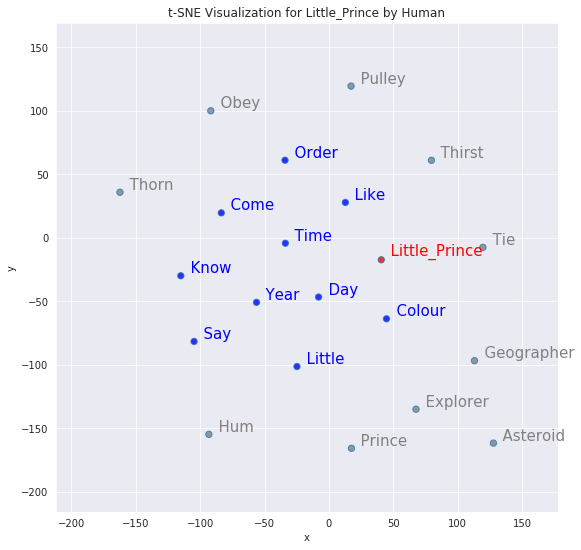

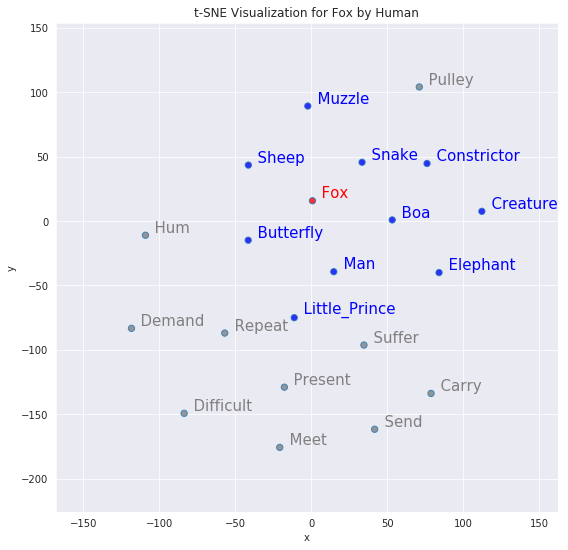

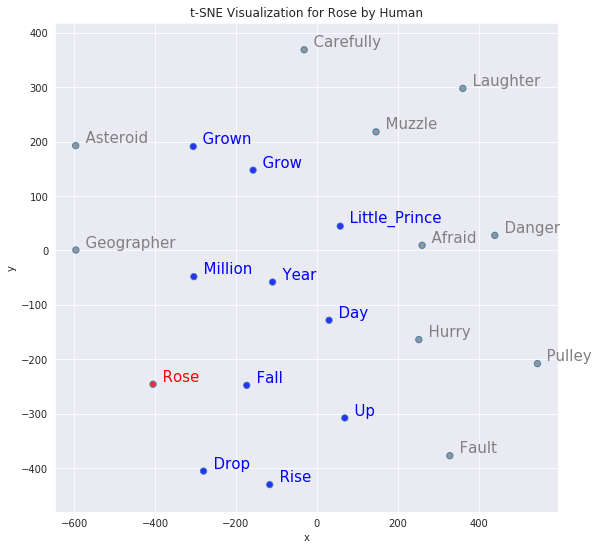

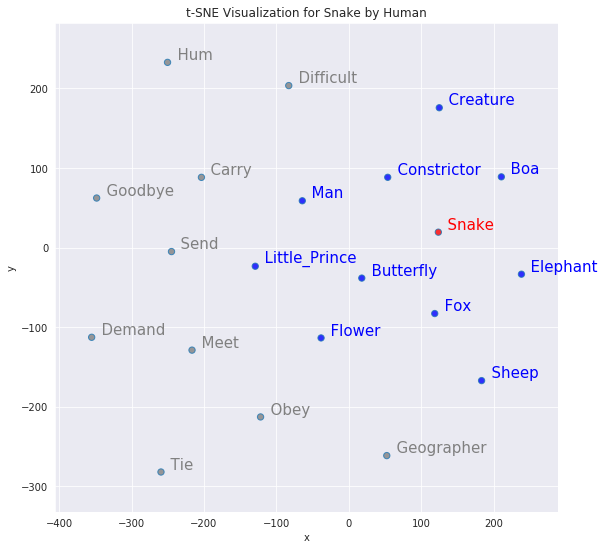

In [0]:
tsnescatterplot(w2v_model_Human, 'little_prince', [i[0] for i in w2v_model_Human.wv.most_similar(negative=["little_prince"])], "Human")
tsnescatterplot(w2v_model_Human, 'fox', [i[0] for i in w2v_model_Human.wv.most_similar(negative=["fox"])], "Human")
tsnescatterplot(w2v_model_Human, 'rose', [i[0] for i in w2v_model_Human.wv.most_similar(negative=["rose"])], "Human")
tsnescatterplot(w2v_model_Human, 'snake', [i[0] for i in w2v_model_Human.wv.most_similar(negative=["snake"])], "Human")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` i

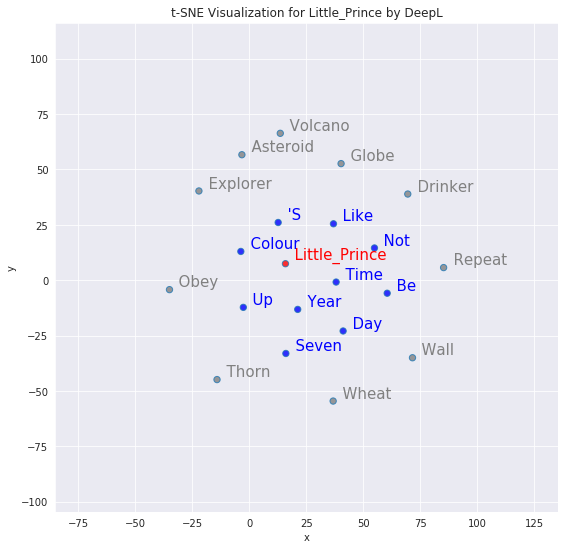

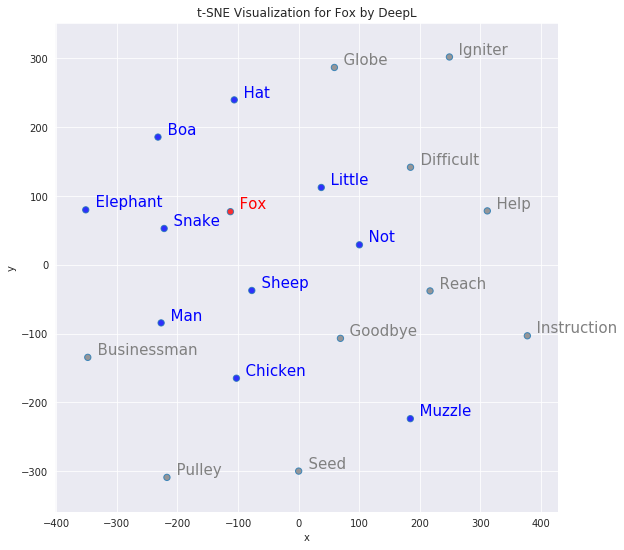

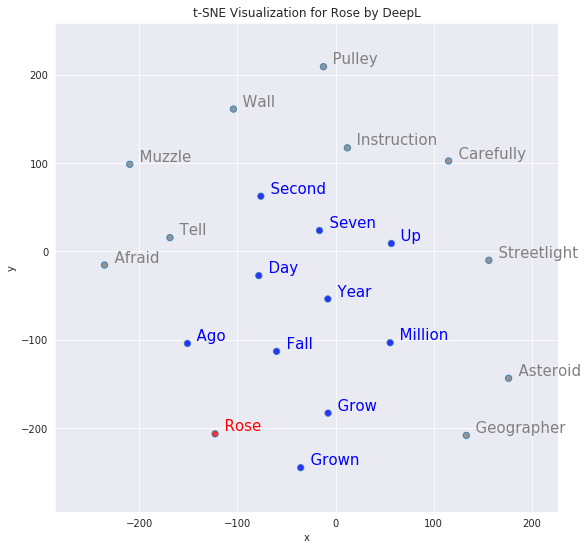

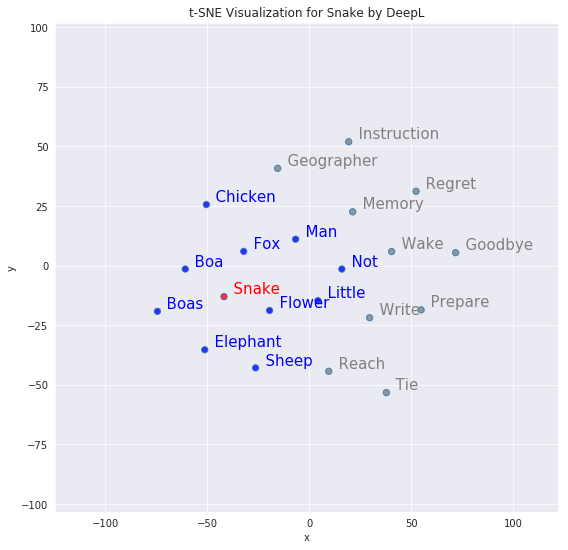

In [0]:
tsnescatterplot(w2v_model_DeepL, 'little_prince', [i[0] for i in w2v_model_DeepL.wv.most_similar(negative=["little_prince"])], "DeepL")
tsnescatterplot(w2v_model_DeepL, 'fox', [i[0] for i in w2v_model_DeepL.wv.most_similar(negative=["fox"])], "DeepL")
tsnescatterplot(w2v_model_DeepL, 'rose', [i[0] for i in w2v_model_DeepL.wv.most_similar(negative=["rose"])], "DeepL")
tsnescatterplot(w2v_model_DeepL, 'snake', [i[0] for i in w2v_model_DeepL.wv.most_similar(negative=["snake"])], "DeepL")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` i

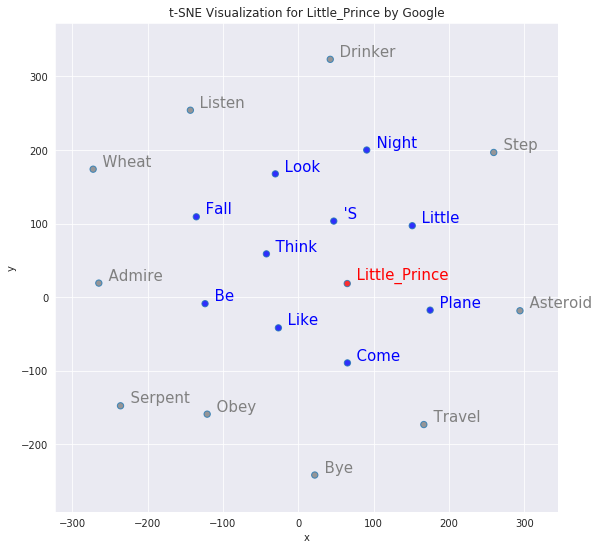

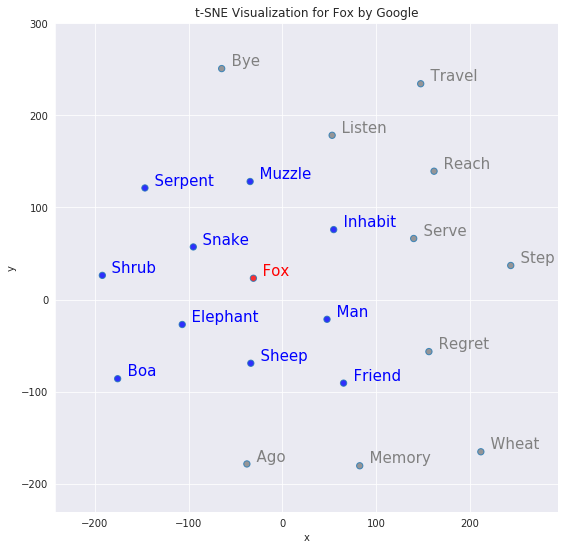

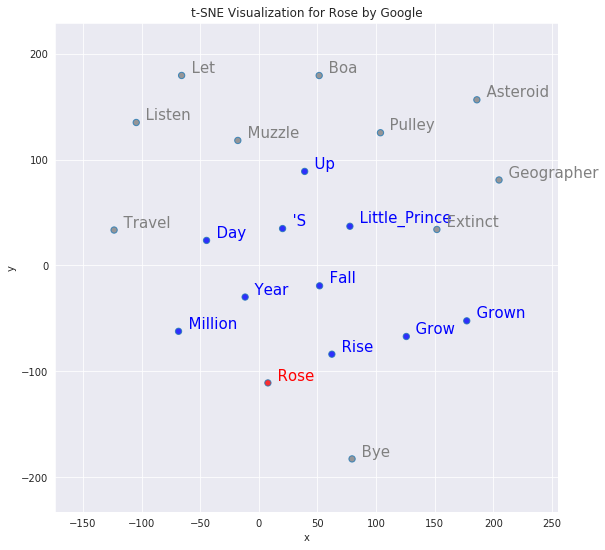

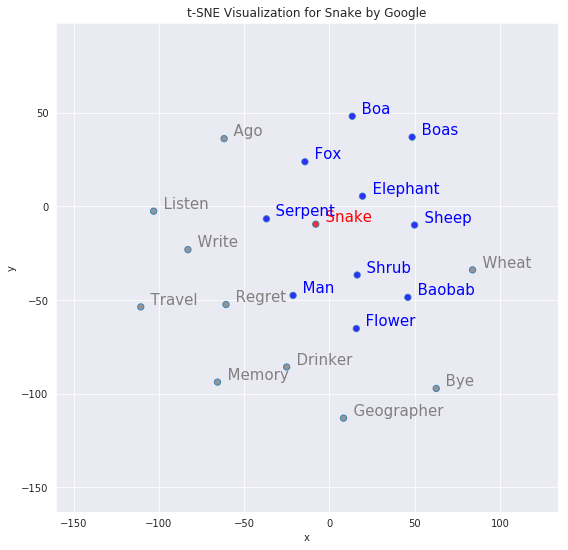

In [0]:
tsnescatterplot(w2v_model_Google, 'little_prince', [i[0] for i in w2v_model_Google.wv.most_similar(negative=["little_prince"])], "Google")
tsnescatterplot(w2v_model_Google, 'fox', [i[0] for i in w2v_model_Google.wv.most_similar(negative=["fox"])], "Google")
tsnescatterplot(w2v_model_Google, 'rose', [i[0] for i in w2v_model_Google.wv.most_similar(negative=["rose"])], "Google")
tsnescatterplot(w2v_model_Google, 'snake', [i[0] for i in w2v_model_Google.wv.most_similar(negative=["snake"])], "Google")


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` i

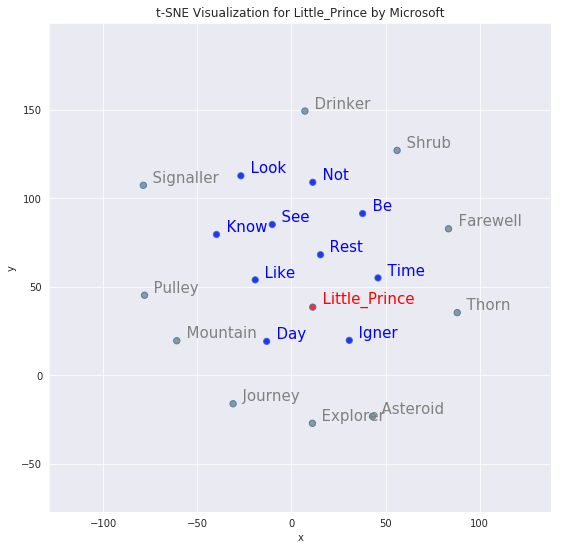

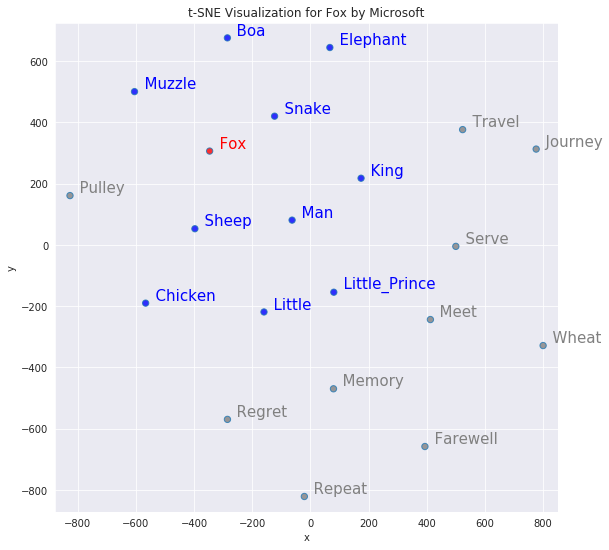

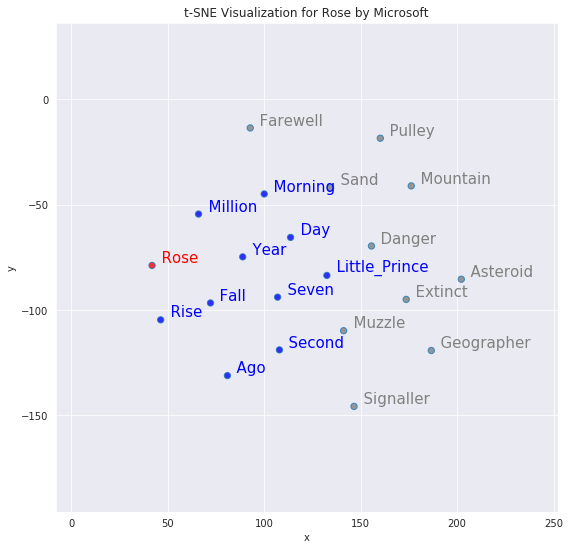

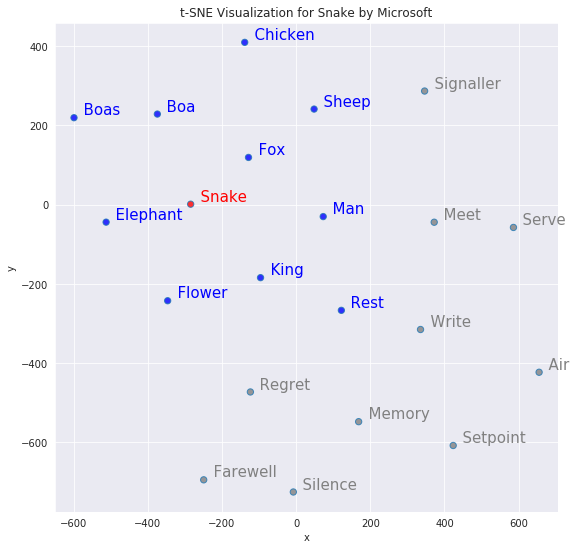

In [0]:
tsnescatterplot(w2v_model_Microsoft, 'little_prince', [i[0] for i in w2v_model_Microsoft.wv.most_similar(negative=["little_prince"])], "Microsoft")
tsnescatterplot(w2v_model_Microsoft, 'fox', [i[0] for i in w2v_model_Microsoft.wv.most_similar(negative=["fox"])], "Microsoft")
tsnescatterplot(w2v_model_Microsoft, 'rose', [i[0] for i in w2v_model_Microsoft.wv.most_similar(negative=["rose"])], "Microsoft")
tsnescatterplot(w2v_model_Microsoft, 'snake', [i[0] for i in w2v_model_Microsoft.wv.most_similar(negative=["snake"])], "Microsoft")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` i

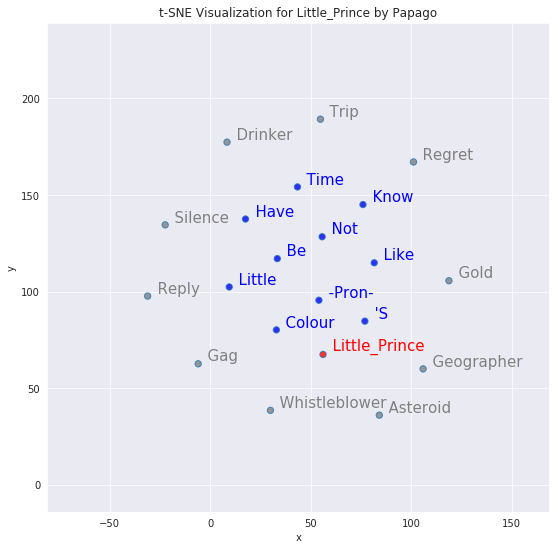

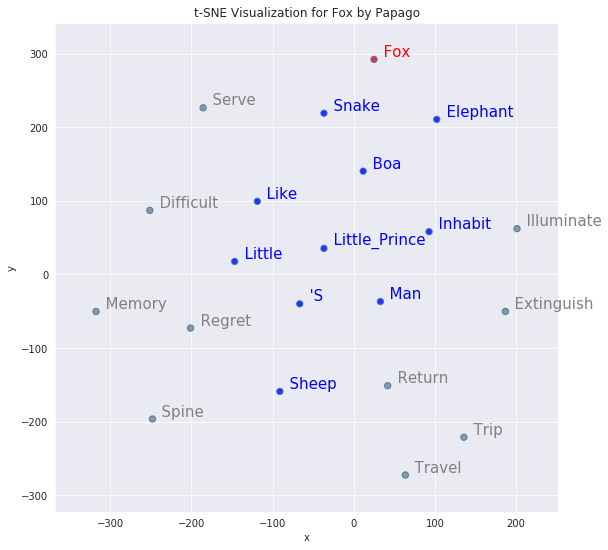

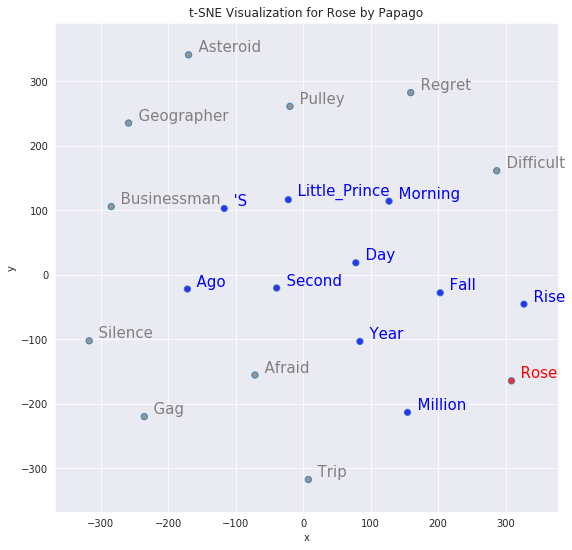

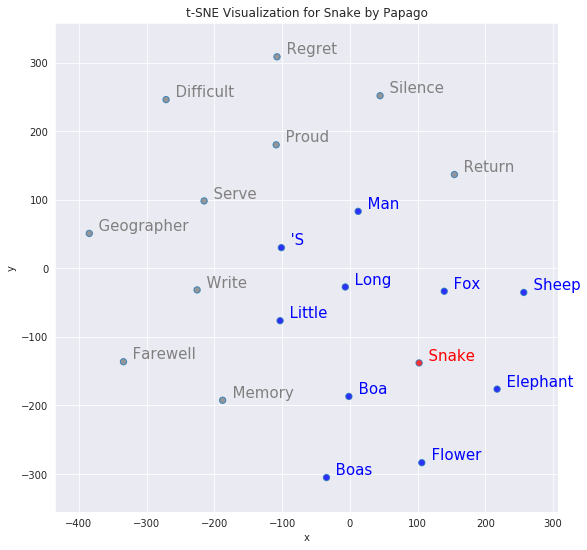

In [0]:
tsnescatterplot(w2v_model_Papago, 'little_prince', [i[0] for i in w2v_model_Papago.wv.most_similar(negative=["little_prince"])], "Papago")
tsnescatterplot(w2v_model_Papago, 'fox', [i[0] for i in w2v_model_Papago.wv.most_similar(negative=["fox"])], "Papago")
tsnescatterplot(w2v_model_Papago, 'rose', [i[0] for i in w2v_model_Papago.wv.most_similar(negative=["rose"])], "Papago")
tsnescatterplot(w2v_model_Papago, 'snake', [i[0] for i in w2v_model_Papago.wv.most_similar(negative=["snake"])], "Papago")

In [0]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'hello', 'bob', 'mel', 'apu', 'marge'])

In [0]:
# Function Definition for t-sne
def tsnescatterplot_3(model, word1,word2, word3, word4, word5, who):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = []
    color_list = []
    word_labels.append(word1)
    color_list.append('red')
    arrays = np.append(arrays, model.wv.__getitem__([word1]), axis=0)
    
    word_labels.append(word2)
    color_list.append('blue')
    arrays = np.append(arrays, model.wv.__getitem__([word2]), axis=0)

    word_labels.append(word3)
    color_list.append('grey')
    arrays = np.append(arrays, model.wv.__getitem__([word3]), axis=0)

    word_labels.append(word4)
    color_list.append('yellow')
    arrays = np.append(arrays, model.wv.__getitem__([word4]), axis=0)

#     word_labels.append(word5)
#     color_list.append('green')
#     arrays = np.append(arrays, model.wv.__getitem__([word5]), axis=0)

        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    #reduc = PCA(n_components=19).fit_transform(arrays)
    reduc = PCA().fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=10, perplexity=10).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
   
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

   
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
           
    plt.title('t-SNE Visualization for {}'.format("characters")+" in "+who)

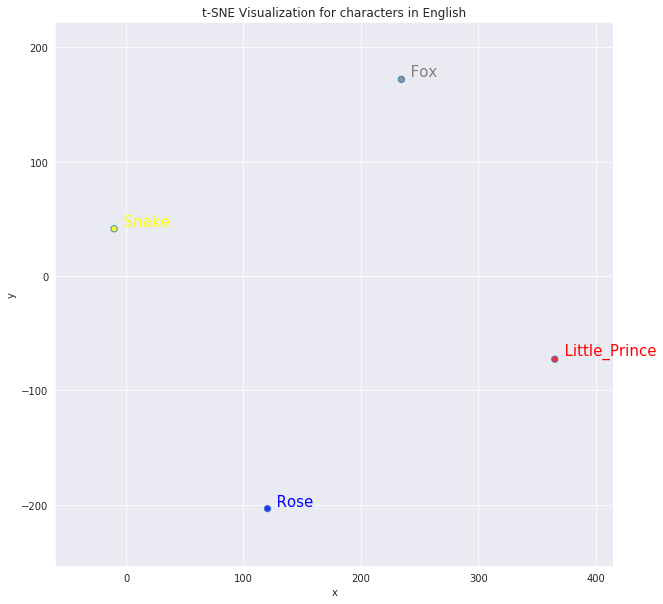

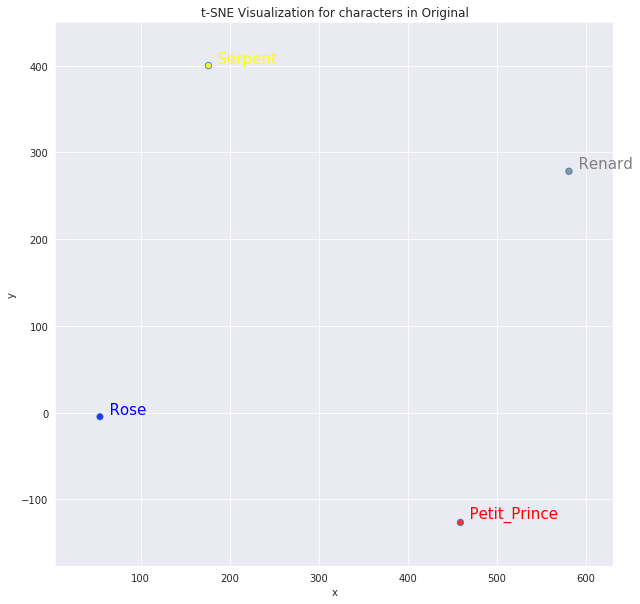

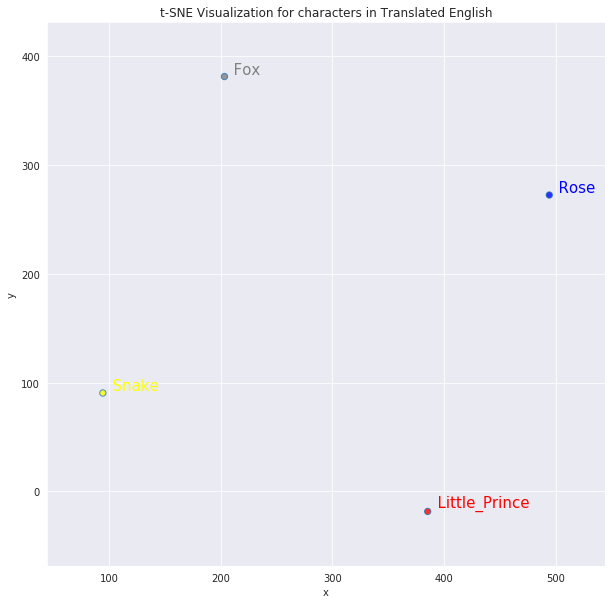

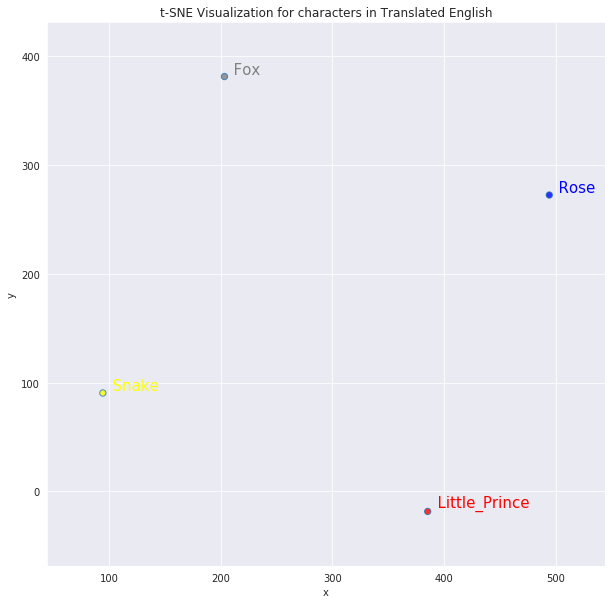

In [0]:
tsnescatterplot_3(w2v_model_Human, 'little_prince', 'rose', 'fox', 'snake', 'baobab', "English")
tsnescatterplot_3(w2v_model_Original, 'petit_prince', 'rose', 'renard', 'serpent', 'baobab', "Original")
tsnescatterplot_3(w2v_model_Google, 'little_prince', 'rose', 'fox', 'snake', 'baobab', "Translated English")
tsne


scatterplot_3(w2v_model_Microsoft, 'little_prince', 'rose', 'fox', 'snake', 'baobab', "Translated English")